<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/model_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preparation

In [1]:
#@title remove repos from disc
%cd /content
!rm -r airbnb_price

/content
rm: cannot remove 'airbnb_price': No such file or directory


In [2]:
#@title Clone repo
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 1340, done.
remote: Counting objects: 100% (1340/1340), done.
remote: Compressing objects: 100% (1267/1267), done.
remote: Total 1340 (delta 799), reused 339 (delta 63), pack-reused 0
Receiving objects: 100% (1340/1340), 11.61 MiB | 11.02 MiB/s, done.
Resolving deltas: 100% (799/799), done.


In [3]:
#@title add paths to library search path
import sys 

sys.path.append("/content/airbnb_price/custom_functions")

In [4]:
#@title Imports and drive
import os
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import requests
from tqdm import tqdm
from scipy.stats.stats import pearsonr
!pip install captum
from captum.attr import visualization as viz
from captum.attr import FeatureAblation
import torchvision.transforms as T
import cv2
import sklearn

# own modules
import general_utils as gu
import picture_model_utils as pu



from google.colab import drive

#@title Mount drive
drive.mount('/content/drive/', force_remount=True)

     |████████████████████████████████| 1.4 MB 10.2 MB/s 
Mounted at /content/drive/


In [5]:
#@title define device

# device
device = gu.get_device()
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB
2 CPUs available


# 1. Model thumbnail pictures

In [6]:
# define train, val split
listings = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle")
trainsplit, valsplit, testsplit = gu.train_val_test_split(listings.index)

In [7]:
# information regarding predictor and response
thumbnail_dir = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_raw"

log_price = listings["log_price"]
log_price = log_price.to_dict()

In [8]:
# make train_dataset and val_dataset and respective dataloader with thumbnails
train_dataset = pu.ThumbnailsDataset(thumbnail_dir=thumbnail_dir, response=log_price, split=trainsplit)
val_dataset = pu.ThumbnailsDataset(thumbnail_dir=thumbnail_dir, response=log_price, split=valsplit)
test_dataset = pu.ThumbnailsDataset(thumbnail_dir=thumbnail_dir, response=log_price, split=testsplit)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [9]:
#@title define models classes
class Model(torch.nn.Module):
    def __init__(self, feature_extractor, finalizer):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.finalizer = finalizer

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.finalizer(x)
    
        return x

    def genembeddings(self, x):
        x = self.feature_extractor(x)
        x = self.finalizer.genembeddings(x)
        
        return x

class Finalizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(512)
        self.conv2 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(512)
        self.conv3 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(512)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop1 = torch.nn.Dropout()
        self.linear1 = torch.nn.Linear(in_features=25088, out_features=1024)
        self.bn4 = torch.nn.BatchNorm1d(1024)
        self.drop2 = torch.nn.Dropout()      
        self.linear2 = torch.nn.Linear(in_features=1024, out_features=100)
        self.bn5 = torch.nn.BatchNorm1d(100)
        self.drop3 = torch.nn.Dropout()
        self.linear3 = torch.nn.Linear(in_features=100, out_features=1)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.drop1(x)
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.drop2(x)
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.drop3(x)
        x = self.linear3(x)

        return x

    def genembeddings(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.drop1(x)
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.drop2(x)
        x = self.bn5(F.relu(self.linear2(x)))
        return x
        

In [10]:
#@title define train functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
    
def train(dataloader, optimizer, model, loss_fn, device, master_bar, scaler):
    model.train()
    epoch_loss = []

    for image, target in fastprogress.progress_bar(dataloader, parent=master_bar):
        
        image, target = image.to(device), target.to(device)
        target = torch.squeeze(target)

        # zero gradient
        optimizer.zero_grad()

        # Forward pass
        prediction = model.forward(image)
        prediction = torch.squeeze(prediction)

        # loss calculation
        loss = loss_fn(prediction, target)

        # Backward pass
        scaler.scale(loss).backward() #loss.backward()
        scaler.step(optimizer) # optimizer.step()
        scaler.update()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(np.sqrt(loss.item()))

    return np.mean(epoch_loss)


def validate(dataloader, model, loss_fn, device, master_bar):
    model.eval()
    epoch_loss = []

    with torch.no_grad():
        for image, target in fastprogress.progress_bar(dataloader, parent=master_bar):
            
            image, target = image.to(device), target.to(device)
            target = torch.squeeze(target)

            # Forward pass
            prediction = model.forward(image)
            prediction = torch.squeeze(prediction)

            # loss calculation
            loss = loss_fn(prediction, target)

            # For plotting the train loss, save it for each sample
            epoch_loss.append(np.sqrt(loss.item()))

    return np.mean(epoch_loss)
    

def run_training(model, optimizer, scheduler, loss_fn, device, num_epochs,
                 train_dataloader, val_dataloader, verbose, 
                 savefolder="training_results1"):
  
    # make path to save performance measures and state dict
    savepath = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_model/" + savefolder
    os.mkdir(savepath)
  
    # technical stuff
    start_time = time.time()
    scaler = torch.cuda.amp.GradScaler()
    master_bar = fastprogress.master_bar(range(num_epochs))

    # instantiate losses
    train_loss = []
    val_loss = []

    for epoch in master_bar:

        # Train the model
        epoch_train_loss = train(train_dataloader, optimizer, model, loss_fn, device, master_bar, scaler)
        #Validate the model
        epoch_val_loss = validate(val_dataloader, model, loss_fn, device, master_bar)

        # update scheduler
        scheduler.step()

        # Save loss and acc for plotting
        train_loss.append(epoch_train_loss)
        val_loss.append(epoch_val_loss)

        if val_loss[-1] <= np.min(val_loss):
            torch.save(model.state_dict(), savepath + "/checkpoint.pt")
            print("saving model...")

        if verbose:
            master_bar.write(
                f'Epoch: {epoch+1}, Train root mse: {epoch_train_loss:.4f}, val root mse: {epoch_val_loss:.4f}')
            
    np.save(savepath + "/trainloss", train_loss)
    np.save(savepath + "/valloss", val_loss)
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_loss, val_loss
    

In [11]:
# define feature extractor
vgg = torchvision.models.vgg19(pretrained=True)
feature_extractor = vgg.features[0:31]

# define finalizer
finalizer = Finalizer()

# define model
model = Model(feature_extractor=feature_extractor, finalizer=finalizer)
model = model.to(device)

# freeze parameters in feature extractor
for name, p in model.named_parameters():
    if "feature_extractor" in name:
        p.requires_grad = False

# print parameters that are optimized
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

finalizer.conv1.weight
finalizer.conv1.bias
finalizer.bn1.weight
finalizer.bn1.bias
finalizer.conv2.weight
finalizer.conv2.bias
finalizer.bn2.weight
finalizer.bn2.bias
finalizer.conv3.weight
finalizer.conv3.bias
finalizer.bn3.weight
finalizer.bn3.bias
finalizer.linear1.weight
finalizer.linear1.bias
finalizer.bn4.weight
finalizer.bn4.bias
finalizer.linear2.weight
finalizer.linear2.bias
finalizer.bn5.weight
finalizer.bn5.bias
finalizer.linear3.weight
finalizer.linear3.bias


In [13]:
# define loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.1 ** (epoch >= 15), 
                                              last_epoch=-1, verbose=True)
loss_fn = torch.nn.MSELoss()

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
train_loss, val_loss = run_training(model=model, optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, device=device, num_epochs=50,
                                    train_dataloader=train_dataloader, val_dataloader=val_dataloader, verbose=True, savefolder="lasttoday")

Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-04.
saving model...
Adjusting learning rate of group 0 to 1.0000e-04.
saving m

# 2. Model Evaluation

In [12]:
# define feature extractor
vgg = torchvision.models.vgg19(pretrained=True)
feature_extractor = vgg.features[0:31]

# define finalizer
finalizer = Finalizer()

# define model
model = Model(feature_extractor=feature_extractor, finalizer=finalizer)
model = model.to(device)

# freeze parameters in feature extractor
for name, p in model.named_parameters():
    if "feature_extractor" in name:
        p.requires_grad = False

result_folder = "bestmodel"
savepath = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_model/" + result_folder
model.load_state_dict(torch.load(savepath + "/checkpoint.pt"))
trainloss = np.load(savepath + "/trainloss.npy")
valloss = np.load(savepath + "/valloss.npy")

In [13]:
ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for x, y in tqdm(val_dataloader):
        x = x.to(device)
        y_pred = model(x)
        y_pred = list(y_pred.data.cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(y)

100%|██████████| 14/14 [10:21<00:00, 44.37s/it]


In [14]:
ys = [i.item() for i in ys]
ypreds = [i.item() for i in ypreds]

(0.462598274361635, 1.8166823501236192e-91)


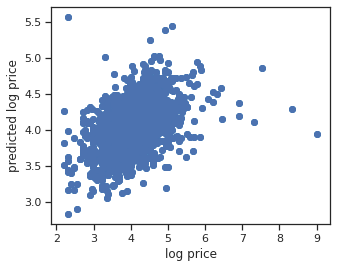

In [15]:
print(pearsonr(ys, ypreds))

plt.figure(figsize=(5,4))
sns.set(style="ticks")
plt.scatter(ys, ypreds, c='#1f77b4')
plt.ylabel("predicted log price")
plt.xlabel("log price")
plt.scatter(ys, ypreds)
plt.savefig(str("/content/file0.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()

In [17]:
print("RMSE val set: ", np.sqrt(sklearn.metrics.mean_squared_error(ys, np.squeeze(ypreds))))
sklearn.metrics.r2_score(ys, ypreds)

RMSE test set:  0.5776578950514722


0.20775150004942633

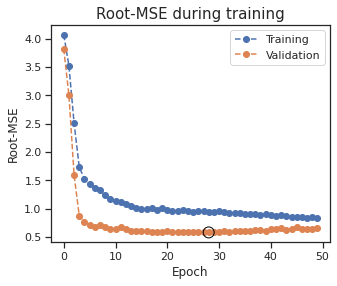

In [18]:
gu.plot("Root-MSE during training", "Root-MSE", (trainloss), (valloss), yscale='linear', legend=["Training", "Validation"],
         thinning=1, save_path="/content/file0.svg")


#3. Select thumbnails for explainability

In [ ]:
# get indices of very high and low predictions
np.random.seed(1)
sorted_indices = torch.argsort(torch.tensor(ypreds))
sorted_indices_low_prediction = sorted_indices[:3]
sorted_indices_high_prediction = sorted_indices[-3:]
sorted_indices_random_prediction = np.random.choice(sorted_indices, size=10, replace=False, p=None)

print("indices lowest 3 predictions: ", val_dataset.split[sorted_indices_low_prediction])
print("indices highest 3 predictions: ", val_dataset.split[sorted_indices_high_prediction])
print("indices 10 random predictions: ", val_dataset.split[sorted_indices_random_prediction])




indices lowest 3 predictions:  [23106156 48650922 18608895]
indices highest 3 predictions:  [15709168 51704242 43722955]
indices 10 random predictions:  Int64Index([49138135, 16919588, 52929748, 21147294,  9398230, 49648865,
            11654647,  3082172, 49647330, 36027297],
           dtype='int64')


# 4. Explainability

In [ ]:
# define feature extractor
vgg = torchvision.models.vgg19(pretrained=True)
feature_extractor = vgg.features[0:31]

# define finalizer
finalizer = Finalizer()

# define model
model = Model(feature_extractor=feature_extractor, finalizer=finalizer)
model = model.to(device)

# freeze parameters in feature extractor
for name, p in model.named_parameters():
    if "feature_extractor" in name:
        p.requires_grad = False

# load model
result_folder = "bestmodel"
savepath = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_model/" + result_folder
model.load_state_dict(torch.load(savepath + "/checkpoint.pt"))

<All keys matched successfully>

In [ ]:
from pickle import TRUE
#@title explainability functions


def generate_heatmap(feature_mask_directory, model, device):
    model = model.eval()
    # used to bring image to vgg input
    img_to_vgg_input = T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    for feature_mask_file in os.listdir(feature_mask_directory):

        # get feature mask in feature_mask_directory
        feature_mask = np.load(feature_mask_directory + "/" + feature_mask_file)
        feature_mask = torch.tensor(feature_mask)
        feature_mask = feature_mask.to(device)

        # get image that corresponds to feature_mask
        condition = TRUE
        temp = ""
        i = 0
        while condition:
            if not (feature_mask_file[i] == "_" or feature_mask_file[i] =="."):
                temp += feature_mask_file[i]
                i += 1
            else:
                condition = False
                
                
        corresponding_thumbnail_file = "thumbnail" + temp + ".npy"
        corresponding_thumbnail = np.load("/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_raw" + "/" + corresponding_thumbnail_file)
        corresponding_thumbnail = torch.tensor(corresponding_thumbnail)
        corresponding_thumbnail = corresponding_thumbnail.to(device)

        # calculate attribution map based on model, input and feature mask
        ablator = FeatureAblation(model)
        attribution_map = ablator.attribute(img_to_vgg_input(torch.permute(corresponding_thumbnail/255, (2, 0, 1))).unsqueeze(0),
                                            target=None,  
                                            feature_mask=feature_mask)
        
        # define figure to plot original picture and heatmap on
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(corresponding_thumbnail.cpu().numpy())

        attribution_map = attribution_map.squeeze().cpu().detach().numpy()
        attribution_map = np.transpose(attribution_map, (1,2,0))
        heatmap = viz.visualize_image_attr(attribution_map,
                                    method="heat_map",
                                    sign="all",
                                    show_colorbar=True,
                                    use_pyplot=False,
                                    plt_fig_axis=(fig, ax[1]))

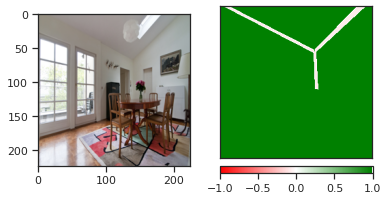

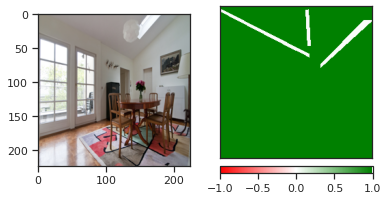

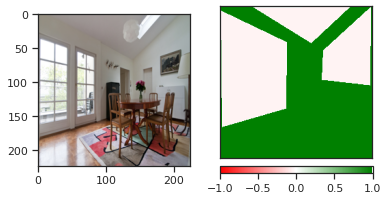

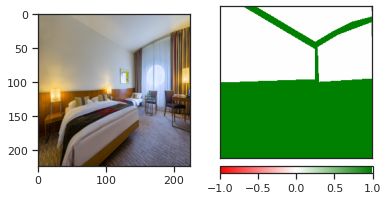

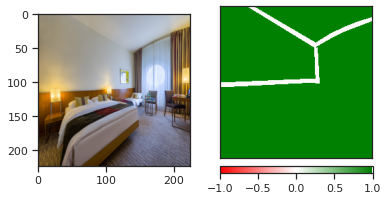

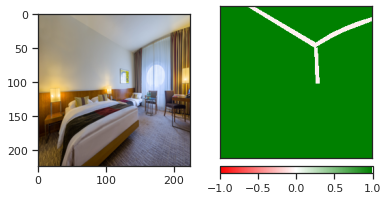

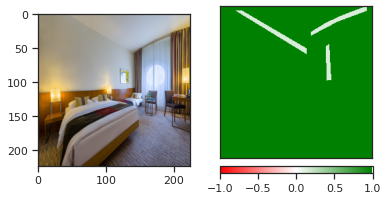

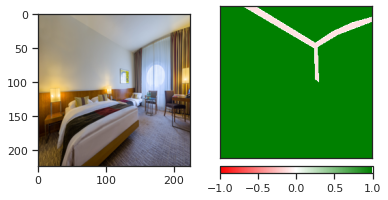

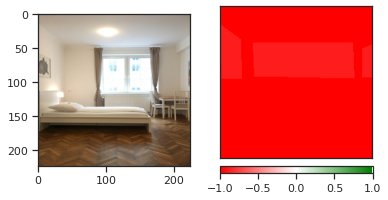

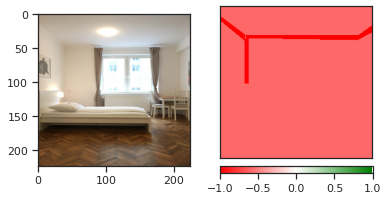

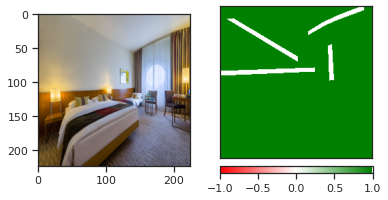

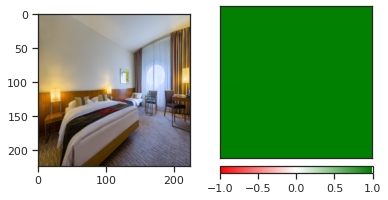

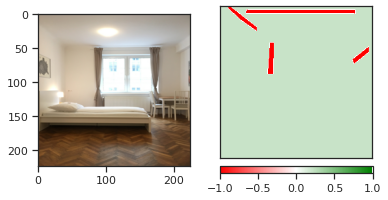

In [ ]:
feature_mask_directory = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_feature_masks/highest3_experiment_numpy"

generate_heatmap(feature_mask_directory=feature_mask_directory, model=model, device=device)

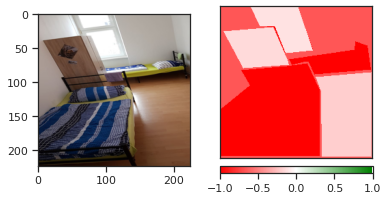

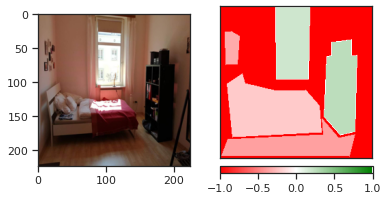

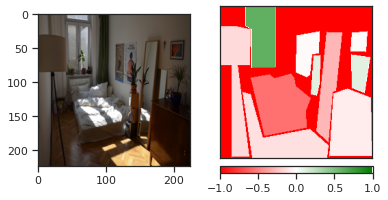

In [ ]:
feature_mask_directory = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_feature_masks/lowest3_numpy"

generate_heatmap(feature_mask_directory=feature_mask_directory, model=model, device=device)

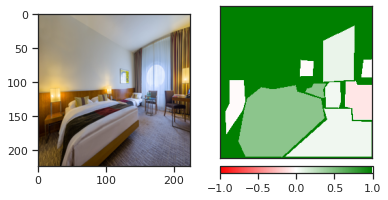

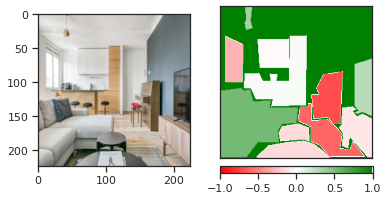

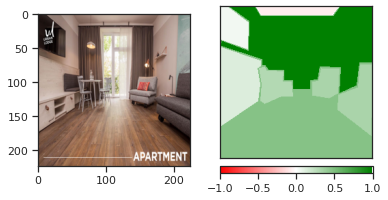

In [ ]:
feature_mask_directory = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_feature_masks/highest3_numpy"

generate_heatmap(feature_mask_directory=feature_mask_directory, model=model, device=device)

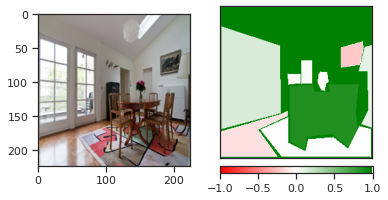

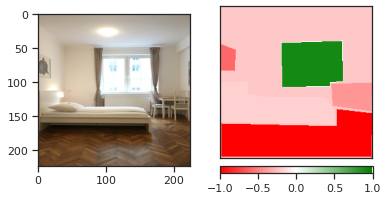

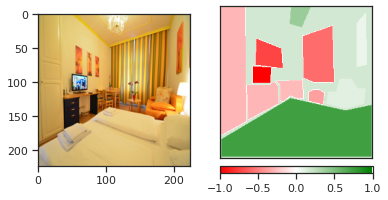

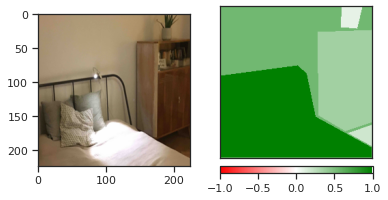

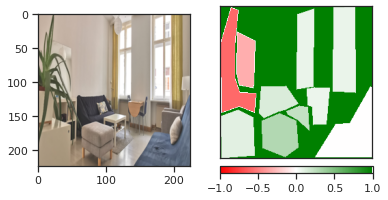

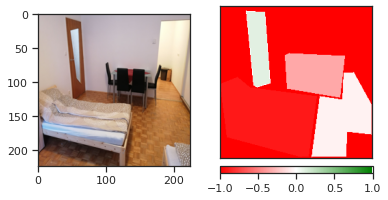

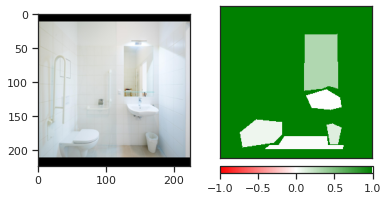

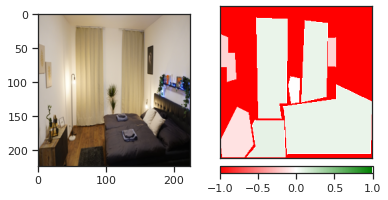

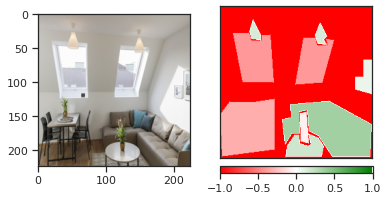

In [ ]:
feature_mask_directory = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_feature_masks/random9_numpy"

generate_heatmap(feature_mask_directory=feature_mask_directory, model=model, device=device)

# Predictions masked images

In [ ]:
listing_id = "9398230.npy"

In [ ]:
def mask_feature(feature_mask, feature_number):
    feature_mask_tmp = feature_mask.copy()
    feature_mask_tmp[feature_mask == feature_number] = 0
    feature_mask_tmp[feature_mask != feature_number] = 100

    return feature_mask_tmp

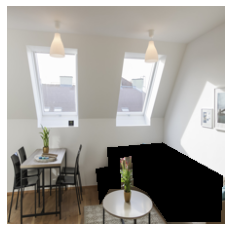

In [ ]:
# plot image without some important areas 
feature_mask = np.load("/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_feature_masks/random9_numpy/" + listing_id)
feature_mask = mask_feature(feature_mask, 2)
feature_mask = np.expand_dims(feature_mask.squeeze(), axis=2).astype(np.uint8)

img_arr = np.load("/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_raw/thumbnail" + listing_id)
img_without_important_areas = cv2.bitwise_and(img_arr, img_arr, mask=feature_mask)
plt.imshow(img_without_important_areas); plt.axis('off'); plt.show()

In [ ]:
# generate prediction for ablated image, be careful to mask out AFTER standardization
import torchvision.transforms as T
img_to_vgg_input = T.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
     )

img_without_important_areas = torch.tensor(img_arr)
img_without_important_areas = (img_without_important_areas / 255)
img_without_important_areas = torch.permute(img_without_important_areas, (2, 0, 1))
img_without_important_areas = img_to_vgg_input(img_without_important_areas)
img_without_important_areas = torch.permute(img_without_important_areas, (1, 2, 0))
img_without_important_areas = np.array(img_without_important_areas)
img_without_important_areas = cv2.bitwise_and(img_without_important_areas, img_without_important_areas, mask=feature_mask)
img_without_important_areas = torch.tensor(img_without_important_areas)
img_without_important_areas = torch.permute(img_without_important_areas, (2, 0, 1))
img_without_important_areas = torch.unsqueeze(img_without_important_areas, 0).to(device)

with torch.no_grad():
    model = model.eval()
    print(model(img_without_important_areas))

tensor([[3.9801]], device='cuda:0')


In [ ]:
img_arr = torch.tensor(img_arr)
img_arr = (img_arr / 255)
img_arr = torch.permute(img_arr, (2, 0, 1))
img_arr = img_to_vgg_input(img_arr)
img_arr = img_arr.to(device)
img_arr = torch.unsqueeze(img_arr, 0).to(device)


# generate prediction for original image
with torch.no_grad():
    model = model.eval()
    print(model(img_arr))

tensor([[4.1079]], device='cuda:0')


# 5. Generate Embeddings

In [ ]:
# define thumbnail_dir
thumbnail_dir = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_raw"

# load model
# define feature extractor
vgg = torchvision.models.vgg19(pretrained=True)
feature_extractor = vgg.features[0:31]

# define finalizer
finalizer = Finalizer()

# define model
model = Model(feature_extractor=feature_extractor, finalizer=finalizer)
model = model.to(device)

# load statedict
result_folder = "bestmodel"
savepath = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_model/" + result_folder
model.load_state_dict(torch.load(savepath + "/checkpoint.pt"))

# make dataset which contains all the data first
listings = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle")

dataset = pu.Shitdataset(thumbnail_dir=thumbnail_dir, index=listings.index)

# make dataloader with all the data
loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=2, batch_size=1)

# generate embeddings
embeddings = torch.empty((len(dataset), 100))
model.eval()
start = 0
indices = []

with torch.no_grad():
    i = 0
    for pic, index in tqdm(loader):
        i += 1
        
        pic = pic.to(device)
        embedding = model.genembeddings(pic)
        embedding = embedding.detach().cpu()
        stop = start + len(pic)
        embeddings[start:stop] = embedding
        start = stop

        indices.append(index.item())

# save embeddings in pandas dataframe

df = pd.Series(embeddings.numpy().tolist(), name="thumbnails", index=indices)
path = "/content/drive/MyDrive/Colab/airbnb/data/embeddings/thumbnails.pickle"
df.to_pickle(path)

100%|██████████| 11404/11404 [59:09<00:00,  3.21it/s]


# 6. Evaluation Munich

In [ ]:
listings = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/munich/listings_workfile.pickle")

# information regarding predictor and response
thumbnail_dir = "/content/drive/MyDrive/Colab/airbnb/munich/thumbnails/thumbnails_raw"

log_price = listings["log_price"]
log_price = log_price.to_dict()

# make train_dataset and val_dataset and respective dataloader with thumbnails
dataset = pu.ThumbnailsDataset(thumbnail_dir=thumbnail_dir, response=log_price, split=listings.index)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)


In [ ]:
# define feature extractor
vgg = torchvision.models.vgg19(pretrained=True)
feature_extractor = vgg.features[0:31]

# define finalizer
finalizer = Finalizer()

# define model
model = Model(feature_extractor=feature_extractor, finalizer=finalizer)
model = model.to(device)

# freeze parameters in feature extractor
for name, p in model.named_parameters():
    if "feature_extractor" in name:
        p.requires_grad = False

result_folder = "bestmodel"
savepath = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_model/" + result_folder
model.load_state_dict(torch.load(savepath + "/checkpoint.pt"))
trainloss = np.load(savepath + "/trainloss.npy")
valloss = np.load(savepath + "/valloss.npy")

In [ ]:
ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for x, y in tqdm(dataloader):
        x = x.to(device)
        y_pred = model(x)
        y_pred = list(y_pred.data.cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(y)

100%|██████████| 8/8 [10:42<00:00, 80.29s/it]


In [ ]:
ys = [i.item() for i in ys]
ypreds = [i.item() for i in ypreds]

(0.2149889545079906, 6.712429191414431e-12)


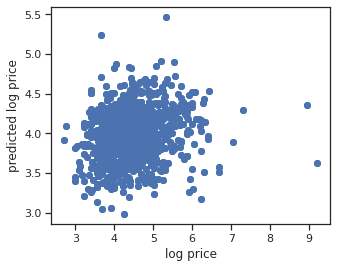

In [ ]:
print(pearsonr(ys, ypreds))

plt.figure(figsize=(5,4))
sns.set(style="ticks")
plt.scatter(ys, ypreds, c='#1f77b4')
plt.ylabel("predicted log price")
plt.xlabel("log price")
plt.scatter(ys, ypreds)
plt.savefig(str("/content/file1.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()

In [ ]:
difference = np.mean(ys) - np.mean(ypreds)
print("root mse without bias correction: ", sklearn.metrics.mean_squared_error(ys, ypreds))
print("root mse with bias correction: ", sklearn.metrics.mean_squared_error(ys, [i + difference for i in ypreds]))

root mse without bias correction:  0.7117348333247472
root mse with bias correction:  0.49435034841226


# 7. Generate Embeddings munich

In [ ]:
# define thumbnail dir of munich data
thumbnail_dir = "/content/drive/MyDrive/Colab/airbnb/munich/thumbnails/thumbnails_raw"

# load model
# define feature extractor
vgg = torchvision.models.vgg19(pretrained=True)
feature_extractor = vgg.features[0:31]

# define finalizer
finalizer = Finalizer()

# define model
model = Model(feature_extractor=feature_extractor, finalizer=finalizer)
model = model.to(device)

# load statedict
result_folder = "bestmodel"
savepath = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_model/" + result_folder
model.load_state_dict(torch.load(savepath + "/checkpoint.pt"))

# make dataset which contains all the data first
listings = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/munich/listings_workfile.pickle")

dataset = pu.Shitdataset(thumbnail_dir=thumbnail_dir, index=listings.index)

# make dataloader with all the data
loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=2, batch_size=1)

# generate embeddings
embeddings = torch.empty((len(dataset), 100))
model.eval()
start = 0
indices = []

with torch.no_grad():
    i = 0
    for pic, index in tqdm(loader):
        i += 1
        
        pic = pic.to(device)
        embedding = model.genembeddings(pic)
        embedding = embedding.detach().cpu()
        stop = start + len(pic)
        embeddings[start:stop] = embedding
        start = stop

        indices.append(index.item())

# save embeddings in pandas dataframe

df = pd.Series(embeddings.numpy().tolist(), name="thumbnails", index=indices)
path = "/content/drive/MyDrive/Colab/airbnb/munich/thumbnails/thumbnails_embeddings.pickle"
df.to_pickle(path)

100%|██████████| 998/998 [00:09<00:00, 109.27it/s]
